In [1]:
# Install required packages
!pip install timm

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.cuda.amp import autocast, GradScaler
from torch.utils.data import DataLoader
import torchvision.datasets as datasets
import torchvision.transforms as transforms

import timm
import numpy as np
import copy
from tqdm import tqdm
import matplotlib.pyplot as plt
import os

# Check device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name()}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 86.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 64.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 46.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 30.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.4 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 2.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 68.5 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.

In [2]:
class ConvNeXtClassifier(nn.Module):
    """Enhanced ConvNeXt model for texture classification."""
    
    def __init__(self, num_classes=47, pretrained=True, mlp_hidden=None, 
                 dropout=0.35, freeze_backbone=True):
        super().__init__()
        
        # Default hidden layers if none provided
        if mlp_hidden is None:
            mlp_hidden = [1024, 512, 256]
        
        # Load pretrained ConvNeXt-XXL backbone
        self.backbone = timm.create_model("convnext_xxlarge", pretrained=pretrained)
        
        # Extract feature dimension
        in_features = self.backbone.head.fc.in_features
        
        # Remove default head
        self.backbone.head.fc = nn.Identity()
        
        # Build custom MLP classifier
        layers = []
        input_dim = in_features
        for h in mlp_hidden:
            layers += [
                nn.Linear(input_dim, h),
                nn.ReLU(inplace=True),
                nn.Dropout(dropout)
            ]
            input_dim = h
        layers.append(nn.Linear(input_dim, num_classes))
        self.classifier = nn.Sequential(*layers)
        
        # Optionally freeze backbone
        if freeze_backbone:
            for param in self.backbone.stem.parameters():
                param.requires_grad = False
            for param in self.backbone.stages.parameters():
                param.requires_grad = False
    
    def forward(self, x):
        x = self.backbone(x)     # Extract features
        x = self.classifier(x)   # Pass through custom MLP head
        return x

In [3]:
class EarlyStopping:
    """Early stopping utility class with improved overfitting detection."""
    
    def __init__(self, patience=10, min_delta=0.01, restore_best_weights=False):
        self.patience = patience
        self.min_delta = min_delta
        self.restore_best_weights = restore_best_weights
        
        self.best_loss = float('inf')
        self.counter = 0
        self.best_weights = None
        self.best_epoch = 0
        self.loss_history = []
    
    def __call__(self, val_loss, model, epoch=None):
        """Returns True if training should be stopped, False otherwise."""
        self.loss_history.append(val_loss)
        
        # Keep only recent history (last 10 epochs)
        if len(self.loss_history) > 10:
            self.loss_history.pop(0)
        
        # Check if this is a significant improvement
        is_improvement = val_loss < self.best_loss - self.min_delta
        
        if is_improvement:
            self.best_loss = val_loss
            self.counter = 0
            self.best_epoch = epoch if epoch is not None else self.best_epoch
            if self.restore_best_weights:
                self.best_weights = copy.deepcopy(model.state_dict())
            return False
        else:
            self.counter += 1
        
        # Additional check for plateauing
        if len(self.loss_history) >= 5:
            recent_losses = self.loss_history[-5:]
            loss_variance = np.var(recent_losses)
            if loss_variance < (self.min_delta / 2) ** 2:
                self.counter += 1
        
        # Check if we should stop
        if self.counter >= self.patience:
            if self.restore_best_weights and self.best_weights is not None:
                model.load_state_dict(self.best_weights)
            return True
        
        return False

In [4]:
class DTDDataModule:
    """Data module for DTD dataset with enhanced augmentations."""
    
    def __init__(self, data_dir='/kaggle/working/data', batch_size=8, num_workers=2):
        self.data_dir = data_dir
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.num_classes = 47
        
        # Enhanced training transforms
        self.train_transform = transforms.Compose([
            transforms.Resize((256, 256)),
            transforms.RandomResizedCrop(224, scale=(0.6, 1.0)),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomVerticalFlip(p=0.3),
            transforms.RandomRotation(30),
            transforms.ColorJitter(
                brightness=0.4,
                contrast=0.4,
                saturation=0.4,
                hue=0.15
            ),
            transforms.RandomPerspective(distortion_scale=0.3, p=0.5),
            transforms.RandomAffine(degrees=15, translate=(0.1, 0.1), scale=(0.9, 1.1)),
            transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 2.0)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            transforms.RandomErasing(p=0.5, scale=(0.02, 0.3)),
        ])
        
        # Validation/Test transforms
        self.val_transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])
    
    def setup(self):
        """Load datasets and create data loaders."""
        print("Loading DTD dataset...")
        
        # Load datasets
        self.train_dataset = datasets.DTD(
            root=self.data_dir, split='train', download=True, transform=self.train_transform
        )
        self.val_dataset = datasets.DTD(
            root=self.data_dir, split='val', download=True, transform=self.val_transform
        )
        self.test_dataset = datasets.DTD(
            root=self.data_dir, split='test', download=True, transform=self.val_transform
        )
        
        # Create data loaders
        self.train_loader = DataLoader(
            self.train_dataset, 
            batch_size=self.batch_size, 
            shuffle=True,
            num_workers=self.num_workers,
            pin_memory=torch.cuda.is_available(),
            drop_last=True
        )
        
        self.val_loader = DataLoader(
            self.val_dataset, 
            batch_size=self.batch_size, 
            shuffle=False,
            num_workers=self.num_workers,
            pin_memory=torch.cuda.is_available()
        )
        
        self.test_loader = DataLoader(
            self.test_dataset, 
            batch_size=self.batch_size, 
            shuffle=False,
            num_workers=self.num_workers,
            pin_memory=torch.cuda.is_available()
        )
        
        print(f"Dataset loaded: {self.num_classes} classes")
        print(f"Train samples: {len(self.train_dataset)}")
        print(f"Val samples: {len(self.val_dataset)}")
        print(f"Test samples: {len(self.test_dataset)}")
        print(f"Train batches: {len(self.train_loader)}")
        print(f"Val batches: {len(self.val_loader)}")
        print(f"Test batches: {len(self.test_loader)}")
        
        return self.train_loader, self.val_loader, self.test_loader

In [5]:
class TextureClassifier:
    """Main trainer class for texture classification."""
    
    def __init__(self, model, device=None, lr=3e-5, weight_decay=0.03, 
                 early_stopping_patience=10, use_amp=True):
        
        # Device setup
        self.device = device if device is not None else torch.device(
            "cuda" if torch.cuda.is_available() else "cpu"
        )
        
        # Model setup
        self.model = model.to(self.device)
        
        # Training components
        self.criterion = nn.CrossEntropyLoss()
        self.optimizer = optim.AdamW(
            self.model.parameters(), lr=lr, weight_decay=weight_decay
        )
        
        # Learning rate scheduler
        self.scheduler = optim.lr_scheduler.ReduceLROnPlateau(
            self.optimizer, mode='min', factor=0.5, patience=5, min_lr=1e-8, verbose=True
        )
        
        # Early stopping
        self.early_stopping = EarlyStopping(
            patience=early_stopping_patience, min_delta=0.02, restore_best_weights=True
        )
        
        # Mixed precision setup
        self.use_amp = use_amp and self.device.type == "cuda"
        if self.use_amp:
            self.scaler = GradScaler()
            print("Mixed precision training enabled")
        else:
            self.scaler = None
            print("Mixed precision disabled")
    
    def train_one_epoch(self, train_loader, epoch):
        """Train for one epoch."""
        self.model.train()
        total_loss = 0.0
        correct = 0
        total = 0
        
        pbar = tqdm(train_loader, desc=f"Epoch {epoch} [Train]", leave=False)
        
        for batch_idx, (data, target) in enumerate(pbar):
            data, target = data.to(self.device), target.to(self.device)
            
            self.optimizer.zero_grad()
            
            # Forward pass with optional mixed precision
            if self.use_amp:
                with autocast():
                    output = self.model(data)
                    loss = self.criterion(output, target)
                
                self.scaler.scale(loss).backward()
                self.scaler.step(self.optimizer)
                self.scaler.update()
            else:
                output = self.model(data)
                loss = self.criterion(output, target)
                loss.backward()
                self.optimizer.step()
            
            # Calculate metrics
            total_loss += loss.item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
            total += target.size(0)
            
            # Update progress bar
            accuracy = 100.0 * correct / total
            avg_loss = total_loss / (batch_idx + 1)
            pbar.set_postfix({
                'Loss': f'{avg_loss:.4f}',
                'Acc': f'{accuracy:.2f}%'
            })
        
        return total_loss / len(train_loader), 100.0 * correct / total
    
    def validate(self, val_loader, epoch):
        """Validate the model."""
        self.model.eval()
        total_loss = 0.0
        correct = 0
        total = 0
        
        with torch.no_grad():
            pbar = tqdm(val_loader, desc=f"Epoch {epoch} [Val]", leave=False)
            
            for batch_idx, (data, target) in enumerate(pbar):
                data, target = data.to(self.device), target.to(self.device)
                
                if self.use_amp:
                    with autocast():
                        output = self.model(data)
                        loss = self.criterion(output, target)
                else:
                    output = self.model(data)
                    loss = self.criterion(output, target)
                
                total_loss += loss.item()
                pred = output.argmax(dim=1, keepdim=True)
                correct += pred.eq(target.view_as(pred)).sum().item()
                total += target.size(0)
                
                accuracy = 100.0 * correct / total
                avg_loss = total_loss / (batch_idx + 1)
                pbar.set_postfix({
                    'Loss': f'{avg_loss:.4f}',
                    'Acc': f'{accuracy:.2f}%'
                })
        
        return total_loss / len(val_loader), 100.0 * correct / total
    
    def fit(self, train_loader, val_loader, epochs=30):
        """Train the model with early stopping."""
        history = {
            "train_loss": [],
            "train_acc": [],
            "val_loss": [],
            "val_acc": [],
            "lr": []
        }
        
        print(f"\nStarting training for up to {epochs} epochs...")
        print("=" * 80)
        
        for epoch in range(1, epochs + 1):
            # Get current learning rate
            current_lr = self.optimizer.param_groups[0]['lr']
            history["lr"].append(current_lr)
            
            # Training
            train_loss, train_acc = self.train_one_epoch(train_loader, epoch)
            history["train_loss"].append(train_loss)
            history["train_acc"].append(train_acc)
            
            # Validation
            val_loss, val_acc = self.validate(val_loader, epoch)
            history["val_loss"].append(val_loss)
            history["val_acc"].append(val_acc)
            
            # Print epoch results
            print(f"Epoch [{epoch:3d}/{epochs}] "
                  f"LR: {current_lr:.2e} | "
                  f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}% "
                  f"| Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%")
            
            # Update learning rate scheduler
            self.scheduler.step(val_loss)
            
            # Check early stopping
            if self.early_stopping(val_loss, self.model, epoch):
                print(f"\n[INFO] Early stopping triggered at epoch {epoch}")
                print(f"[INFO] Best validation loss: {self.early_stopping.best_loss:.4f} (epoch {self.early_stopping.best_epoch})")
                print("[INFO] Restored best model weights")
                break
            elif self.early_stopping.counter > 0:
                print(f"[INFO] Early stopping: {self.early_stopping.counter}/{self.early_stopping.patience}")
            else:
                print(f"[INFO] New best validation loss: {val_loss:.4f}")
        
        print("=" * 80)
        print("Training completed!")
        print(f"Best validation loss achieved: {self.early_stopping.best_loss:.4f}")
        
        return history
    
    def evaluate(self, test_loader):
        """Evaluate the model on test dataset."""
        self.model.eval()
        total_loss = 0.0
        correct = 0
        total = 0
        
        with torch.no_grad():
            pbar = tqdm(test_loader, desc="Testing")
            
            for batch_idx, (data, target) in enumerate(pbar):
                data, target = data.to(self.device), target.to(self.device)
                
                if self.use_amp:
                    with autocast():
                        output = self.model(data)
                        loss = self.criterion(output, target)
                else:
                    output = self.model(data)
                    loss = self.criterion(output, target)
                
                total_loss += loss.item()
                pred = output.argmax(dim=1, keepdim=True)
                correct += pred.eq(target.view_as(pred)).sum().item()
                total += target.size(0)
                
                accuracy = 100.0 * correct / total
                avg_loss = total_loss / (batch_idx + 1)
                pbar.set_postfix({
                    'Loss': f'{avg_loss:.4f}',
                    'Acc': f'{accuracy:.2f}%'
                })
        
        test_loss = total_loss / len(test_loader)
        test_acc = 100.0 * correct / total
        
        print("=" * 50)
        print("Test Results:")
        print(f"   Test Loss: {test_loss:.4f}")
        print(f"   Test Accuracy: {test_acc:.2f}%")
        print(f"   Correct Predictions: {correct}/{total}")
        print("=" * 50)
        
        return test_loss, test_acc
    
    def get_model_info(self):
        """Print model information."""
        total_params = sum(p.numel() for p in self.model.parameters())
        trainable_params = sum(p.numel() for p in self.model.parameters() if p.requires_grad)
        
        print("=" * 60)
        print("Model Information:")
        print(f"   Total Parameters: {total_params:,}")
        print(f"   Trainable Parameters: {trainable_params:,}")
        print(f"   Non-trainable Parameters: {total_params - trainable_params:,}")
        print(f"   Device: {self.device}")
        print(f"   Mixed Precision: {self.use_amp}")
        print(f"   Model Type: {type(self.model).__name__}")
        
        # Calculate model size in MB
        model_size = sum(p.numel() * p.element_size() for p in self.model.parameters()) / (1024 * 1024)
        print(f"   Model Size: {model_size:.2f} MB")
        print("=" * 60)

In [6]:
# Initialize data module
print("Setting up data...")
data_module = DTDDataModule(batch_size=16, num_workers=2)
train_loader, val_loader, test_loader = data_module.setup()

# Create model
print("\nCreating ConvNeXt model...")
model = ConvNeXtClassifier(
    num_classes=47,
    pretrained=True,
    mlp_hidden=[1024, 512, 256],
    dropout=0.5,
    freeze_backbone=True
)

# Create trainer
print("\nCreating trainer...")
trainer = TextureClassifier(
    model=model,
    device=device,
    lr=5e-5,
    weight_decay=0.03,
    early_stopping_patience=10,
    use_amp=True
)

# Print model info
trainer.get_model_info()

Setting up data...
Loading DTD dataset...


100%|██████████| 625M/625M [00:17<00:00, 35.6MB/s] 


Dataset loaded: 47 classes
Train samples: 1880
Val samples: 1880
Test samples: 1880
Train batches: 117
Val batches: 118
Test batches: 118

Creating ConvNeXt model...


model.safetensors:   0%|          | 0.00/3.39G [00:00<?, ?B/s]


Creating trainer...
Mixed precision training enabled
Model Information:
   Total Parameters: 847,212,975
   Trainable Parameters: 3,821,103
   Non-trainable Parameters: 843,391,872
   Device: cuda
   Mixed Precision: True
   Model Type: ConvNeXtClassifier
   Model Size: 3231.86 MB


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
/tmp/ipykernel_36/1432114889.py:34: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = GradScaler()


In [7]:
# Train the model
print("\n" + "="*60)
print("TRAINING CONVNEXT MODEL")
print("="*60)

history = trainer.fit(train_loader, val_loader, epochs=50)


TRAINING CONVNEXT MODEL

Starting training for up to 50 epochs...


Epoch 1 [Train]:   0%|          | 0/117 [00:00<?, ?it/s]/tmp/ipykernel_36/1432114889.py:56: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 1 [Val]:   0%|          | 0/118 [00:00<?, ?it/s]                                    /tmp/ipykernel_36/1432114889.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [  1/50] LR: 5.00e-05 | Train Loss: 3.8309 | Train Acc: 3.15% | Val Loss: 3.7837 | Val Acc: 15.74%
[INFO] New best validation loss: 3.7837


Epoch [  2/50] LR: 5.00e-05 | Train Loss: 3.7529 | Train Acc: 6.73% | Val Loss: 3.6555 | Val Acc: 45.53%
[INFO] New best validation loss: 3.6555


Epoch [  3/50] LR: 5.00e-05 | Train Loss: 3.5930 | Train Acc: 14.90% | Val Loss: 3.3816 | Val Acc: 55.69%
[INFO] New best validation loss: 3.3816


Epoch [  4/50] LR: 5.00e-05 | Train Loss: 3.2791 | Train Acc: 22.76% | Val Loss: 2.9204 | Val Acc: 59.04%
[INFO] New best validation loss: 2.9204


Epoch [  5/50] LR: 5.00e-05 | Train Loss: 2.8646 | Train Acc: 31.30% | Val Loss: 2.4287 | Val Acc: 63.30%
[INFO] New best validation loss: 2.4287


Epoch [  6/50] LR: 5.00e-05 | Train Loss: 2.5376 | Train Acc: 37.61% | Val Loss: 2.0439 | Val Acc: 66.76%
[INFO] New best validation loss: 2.0439


Epoch [  7/50] LR: 5.00e-05 | Train Loss: 2.2572 | Train Acc: 43.54% | Val Loss: 1.7540 | Val Acc: 69.89%
[INFO] New best validation loss: 1.7540


Epoch [  8/50] LR: 5.00e-05 | Train Loss: 2.0509 | Train Acc: 46.85% | Val Loss: 1.5637 | Val Acc: 71.22%
[INFO] New best validation loss: 1.5637


Epoch [  9/50] LR: 5.00e-05 | Train Loss: 1.8951 | Train Acc: 50.91% | Val Loss: 1.4207 | Val Acc: 72.82%
[INFO] New best validation loss: 1.4207


Epoch [ 10/50] LR: 5.00e-05 | Train Loss: 1.7785 | Train Acc: 52.83% | Val Loss: 1.3109 | Val Acc: 73.09%
[INFO] New best validation loss: 1.3109


Epoch [ 11/50] LR: 5.00e-05 | Train Loss: 1.6686 | Train Acc: 53.63% | Val Loss: 1.2339 | Val Acc: 73.09%
[INFO] New best validation loss: 1.2339


Epoch [ 12/50] LR: 5.00e-05 | Train Loss: 1.6336 | Train Acc: 55.45% | Val Loss: 1.1553 | Val Acc: 74.31%
[INFO] New best validation loss: 1.1553


Epoch [ 13/50] LR: 5.00e-05 | Train Loss: 1.5218 | Train Acc: 58.55% | Val Loss: 1.1054 | Val Acc: 75.00%
[INFO] New best validation loss: 1.1054


Epoch [ 14/50] LR: 5.00e-05 | Train Loss: 1.4768 | Train Acc: 58.39% | Val Loss: 1.0703 | Val Acc: 74.73%
[INFO] New best validation loss: 1.0703


Epoch [ 15/50] LR: 5.00e-05 | Train Loss: 1.4489 | Train Acc: 59.88% | Val Loss: 1.0343 | Val Acc: 75.85%
[INFO] New best validation loss: 1.0343


Epoch [ 16/50] LR: 5.00e-05 | Train Loss: 1.3521 | Train Acc: 62.29% | Val Loss: 0.9884 | Val Acc: 76.28%
[INFO] New best validation loss: 0.9884


Epoch [ 17/50] LR: 5.00e-05 | Train Loss: 1.3637 | Train Acc: 61.27% | Val Loss: 0.9495 | Val Acc: 77.23%
[INFO] New best validation loss: 0.9495


Epoch [ 18/50] LR: 5.00e-05 | Train Loss: 1.3389 | Train Acc: 62.13% | Val Loss: 0.9338 | Val Acc: 76.44%
[INFO] Early stopping: 1/10


Epoch [ 19/50] LR: 5.00e-05 | Train Loss: 1.2483 | Train Acc: 63.94% | Val Loss: 0.9091 | Val Acc: 77.18%
[INFO] New best validation loss: 0.9091


Epoch [ 20/50] LR: 5.00e-05 | Train Loss: 1.2519 | Train Acc: 64.69% | Val Loss: 0.8827 | Val Acc: 77.61%
[INFO] New best validation loss: 0.8827


Epoch [ 21/50] LR: 5.00e-05 | Train Loss: 1.1945 | Train Acc: 65.54% | Val Loss: 0.8786 | Val Acc: 76.86%
[INFO] Early stopping: 1/10


Epoch [ 22/50] LR: 5.00e-05 | Train Loss: 1.1805 | Train Acc: 66.72% | Val Loss: 0.8573 | Val Acc: 76.97%
[INFO] New best validation loss: 0.8573


Epoch [ 23/50] LR: 5.00e-05 | Train Loss: 1.1295 | Train Acc: 68.38% | Val Loss: 0.8331 | Val Acc: 77.93%
[INFO] New best validation loss: 0.8331


Epoch [ 24/50] LR: 5.00e-05 | Train Loss: 1.1152 | Train Acc: 67.47% | Val Loss: 0.8222 | Val Acc: 77.23%
[INFO] Early stopping: 1/10


Epoch [ 25/50] LR: 5.00e-05 | Train Loss: 1.0879 | Train Acc: 69.02% | Val Loss: 0.8080 | Val Acc: 78.03%
[INFO] New best validation loss: 0.8080


Epoch [ 26/50] LR: 5.00e-05 | Train Loss: 1.0563 | Train Acc: 69.87% | Val Loss: 0.8052 | Val Acc: 77.98%
[INFO] Early stopping: 1/10


Epoch [ 27/50] LR: 5.00e-05 | Train Loss: 1.0363 | Train Acc: 70.46% | Val Loss: 0.7799 | Val Acc: 78.56%
[INFO] New best validation loss: 0.7799


Epoch [ 28/50] LR: 5.00e-05 | Train Loss: 1.0579 | Train Acc: 69.07% | Val Loss: 0.7750 | Val Acc: 78.14%
[INFO] Early stopping: 1/10


Epoch [ 29/50] LR: 5.00e-05 | Train Loss: 1.0281 | Train Acc: 70.46% | Val Loss: 0.7653 | Val Acc: 78.30%
[INFO] Early stopping: 2/10


Epoch [ 30/50] LR: 5.00e-05 | Train Loss: 0.9819 | Train Acc: 70.83% | Val Loss: 0.7569 | Val Acc: 77.82%
[INFO] New best validation loss: 0.7569


Epoch [ 31/50] LR: 5.00e-05 | Train Loss: 0.9752 | Train Acc: 72.28% | Val Loss: 0.7546 | Val Acc: 77.93%
[INFO] Early stopping: 2/10


Epoch [ 32/50] LR: 5.00e-05 | Train Loss: 0.9420 | Train Acc: 72.54% | Val Loss: 0.7494 | Val Acc: 78.35%
[INFO] Early stopping: 4/10


Epoch [ 33/50] LR: 5.00e-05 | Train Loss: 0.9252 | Train Acc: 72.33% | Val Loss: 0.7345 | Val Acc: 78.72%
[INFO] New best validation loss: 0.7345


Epoch [ 34/50] LR: 5.00e-05 | Train Loss: 0.9508 | Train Acc: 71.21% | Val Loss: 0.7436 | Val Acc: 78.94%
[INFO] Early stopping: 2/10


Epoch [ 35/50] LR: 5.00e-05 | Train Loss: 0.8933 | Train Acc: 74.20% | Val Loss: 0.7246 | Val Acc: 78.72%
[INFO] Early stopping: 3/10


Epoch [ 36/50] LR: 5.00e-05 | Train Loss: 0.9159 | Train Acc: 74.25% | Val Loss: 0.7350 | Val Acc: 78.67%
[INFO] Early stopping: 5/10


Epoch [ 37/50] LR: 5.00e-05 | Train Loss: 0.8842 | Train Acc: 73.93% | Val Loss: 0.7200 | Val Acc: 78.88%
[INFO] Early stopping: 7/10


Epoch [ 38/50] LR: 5.00e-05 | Train Loss: 0.8345 | Train Acc: 74.52% | Val Loss: 0.7135 | Val Acc: 78.99%
[INFO] New best validation loss: 0.7135


Epoch [ 39/50] LR: 5.00e-05 | Train Loss: 0.8420 | Train Acc: 75.05% | Val Loss: 0.7224 | Val Acc: 78.88%
[INFO] Early stopping: 2/10


Epoch [ 40/50] LR: 5.00e-05 | Train Loss: 0.9026 | Train Acc: 74.31% | Val Loss: 0.7232 | Val Acc: 78.72%
[INFO] Early stopping: 4/10


Epoch [ 41/50] LR: 5.00e-05 | Train Loss: 0.8450 | Train Acc: 75.53% | Val Loss: 0.7203 | Val Acc: 78.30%
[INFO] Early stopping: 6/10


Epoch [ 42/50] LR: 5.00e-05 | Train Loss: 0.8211 | Train Acc: 76.50% | Val Loss: 0.7277 | Val Acc: 78.78%
[INFO] Early stopping: 8/10


Epoch [ 43/50] LR: 5.00e-05 | Train Loss: 0.8330 | Train Acc: 75.11% | Val Loss: 0.7098 | Val Acc: 78.51%

[INFO] Early stopping triggered at epoch 43
[INFO] Best validation loss: 0.7135 (epoch 38)
[INFO] Restored best model weights
Training completed!
Best validation loss achieved: 0.7135



EVALUATING MODEL


Testing:   0%|          | 0/118 [00:00<?, ?it/s]/tmp/ipykernel_36/1432114889.py:188: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Testing: 100%|██████████| 118/118 [00:49<00:00,  2.39it/s, Loss=0.6847, Acc=80.59%]


Test Results:
   Test Loss: 0.6847
   Test Accuracy: 80.59%
   Correct Predictions: 1515/1880

Model saved as 'convnext_dtd_acc_80.59.pth' in /kaggle/working/
File size: 3232.02 MB
Training plot saved as 'training_plot_acc_80.59.png'


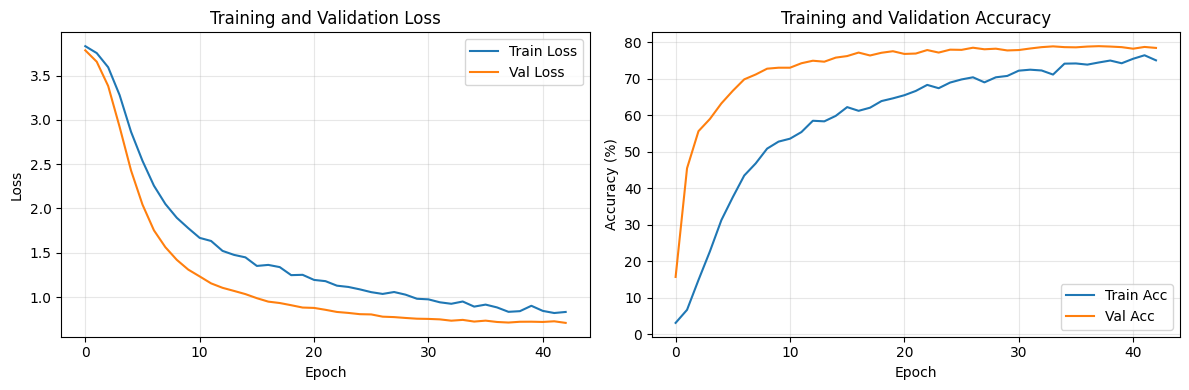


FINAL RESULTS
Test Loss: 0.6847
Test Accuracy: 80.59%
Final Train Accuracy: 75.11%
Final Val Accuracy: 78.51%

SAVED FILES:
   • convnext_dtd_acc_80.59.pth
   • training_plot_acc_80.59.png
   • Location: /kaggle/working/
SUCCESS: Model file verified: convnext_dtd_acc_80.59.pth
SUCCESS: Plot file verified: training_plot_acc_80.59.png


In [10]:
# Evaluate on test set
print("\n" + "="*60)
print("EVALUATING MODEL")
print("="*60)

test_loss, test_acc = trainer.evaluate(test_loader)

# Save model in Kaggle working directory
import os

# Create filename with accuracy for easy identification
model_filename = f"convnext_dtd_acc_{test_acc:.2f}.pth"
model_path = os.path.join("/kaggle/working", model_filename)

# Save model state dict
torch.save(model.state_dict(), model_path)
print(f"\nModel saved as '{model_filename}' in /kaggle/working/")

# Check file size
file_size = os.path.getsize(model_path) / (1024 * 1024)  # Size in MB
print(f"File size: {file_size:.2f} MB")

# Plot training history
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Val Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(history['train_acc'], label='Train Acc')
plt.plot(history['val_acc'], label='Val Acc')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()

# Save plot in working directory too
plot_filename = f"training_plot_acc_{test_acc:.2f}.png"
plot_path = os.path.join("/kaggle/working", plot_filename)
plt.savefig(plot_path, dpi=300, bbox_inches='tight')
print(f"Training plot saved as '{plot_filename}'")

plt.show()

# Final results summary
print("\n" + "="*60)
print("FINAL RESULTS")
print("="*60)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.2f}%")
print(f"Final Train Accuracy: {history['train_acc'][-1]:.2f}%")
print(f"Final Val Accuracy: {history['val_acc'][-1]:.2f}%")

# Show saved files
print(f"\nSAVED FILES:")
print(f"   • {model_filename}")
print(f"   • {plot_filename}")
print(f"   • Location: /kaggle/working/")
print("="*60)

# Verify files exist
if os.path.exists(model_path):
    print(f"SUCCESS: Model file verified: {model_filename}")
else:
    print(f"ERROR: Model save failed!")

if os.path.exists(plot_path):
    print(f"SUCCESS: Plot file verified: {plot_filename}")
else:
    print(f"ERROR: Plot save failed!")